In [97]:
from skimage import io
import matplotlib.pylab as plt
import numpy as np
from skimage.draw import line_nd
from skimage.util import img_as_ubyte, img_as_float64
import glob
from ipywidgets import interact, Dropdown, IntSlider, Layout, Checkbox, Button, HTML
from IPython.display import display
import pydicom
import random
import datetime
import re

### Algorytm Bresenhama

In [55]:
def bresenham(x0, y0, x1, y1):
    points = []
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((y0, x0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [56]:
# makes image bigger (so that circle will be inside)
def pad_image(image):
    original_size = image.shape
    image_center = (original_size[0] // 2, original_size[1] // 2)
    required_radius = int(max(image_center) * np.sqrt(2))

    padding = max(0, required_radius - max(image_center))

    if padding > 0:
        image = np.pad(image, ((padding, padding), (padding, padding)), mode='constant', constant_values=0)
    
    return image

# Transformata Radona

In [57]:
def radon_transform(image, detectors = 180, detectors_angular_span = 180, step = 1):
    image_center = (image.shape[0] // 2, image.shape[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    emiter_angles = np.deg2rad(np.arange(0, 360, step))
    radon_image = np.zeros((len(emiter_angles), detectors), dtype=image.dtype)

    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i, angle in enumerate(emiter_angles):
        emiter_pos = (int(image_radius * np.cos(angle) + image_center[0]), 
                      int(image_radius * np.sin(angle) + image_center[1]))

        for j in range(detectors):
            detector_pos = (int(image_radius * (np.cos(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0]),
                            int(image_radius * (np.sin(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1]))

            line_pixels = bresenham(emiter_pos[0], emiter_pos[1], detector_pos[0], detector_pos[1])
            
            valid_pixels = [(y, x) for y, x in line_pixels if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]]

            if valid_pixels:
                radon_image[i, j] = np.mean([image[y, x] for y, x in valid_pixels])

    return radon_image

# Odwrócona transformata Radona

In [58]:
def inverse_radon_transform(image, image_size, detectors_angular_span = 180, step = 1):
    reconstructed_image = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    
    # get scans/detectors from image
    scans = image.shape[0]
    detectors = image.shape[1]

    image_center = (image_size[0] // 2, image_size[1] // 2)
    image_radius = max(image_center) * np.sqrt(2)

    emiter_angles = np.deg2rad(np.arange(0, 360, step))
    detectors_angle = np.deg2rad(detectors_angular_span)
    detectors_gap = detectors_angle / (detectors - 1)

    for i, angle in enumerate(emiter_angles):
        emiter_pos = (int(image_radius * np.cos(angle) + image_center[0]), 
                        int(image_radius * np.sin(angle) + image_center[1]))

        for j in range(detectors):
            detector_pos = (int(image_radius * (np.cos(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[0]),
                            int(image_radius * (np.sin(angle + np.pi - detectors_angle / 2 + j * detectors_gap)) + image_center[1]))

            line_pixels = bresenham(emiter_pos[0], emiter_pos[1], detector_pos[0], detector_pos[1])

            valid_pixels = [(y, x) for y, x in line_pixels if 0 <= y < image_size[0] and 0 <= x < image_size[1]]
            if valid_pixels:
                rows, cols = zip(*valid_pixels)
                reconstructed_image[rows, cols] += image[i, j] #/ len(valid_pixels)

    return reconstructed_image

# Filtr sinogramu

In [59]:
def filter_sinogram(image, kernel_size=21):
    # make it odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    kernel = np.zeros(kernel_size)
    kernel_center = kernel_size // 2
    kernel[kernel_center] = 1
    for i in range(kernel_center + 1, kernel_size, 2):
        val = (-4 / np.pi**2) / (i - kernel_center)**2
        kernel[i] = val
        kernel[-(i + 1)] = val

    filtered_image = np.zeros((image.shape[0], image.shape[1]), dtype=image.dtype)
    for i in range(image.shape[0]):
        filtered_image[i, :] = np.convolve(image[i, :], kernel, mode='same')
    return filtered_image

# Pliki DICOM

## Zapis pliku DICOM

In [94]:
def save_DICOM(image, patient_id, patient_name, date, comment="A DICOM File", filename="saved_dicom.dcm"):
    ds = pydicom.Dataset()

    ds.PatientName = patient_name
    ds.PatientID = str(patient_id)
    ds.Modality = "CT"
    ds.StudyDate = datetime.datetime.strptime(date, "%d.%m.%Y")
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.SOPClassUID = pydicom.uid.CTImageStorage
    ds.ImageType = ["ORIGINAL", "PRIMARY", "AXIAL"]
    ds.InstanceNumber = str(random.randint(1, 100))
    ds.ImagesInAcquisition = "1"
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.Rows, ds.Columns = image.shape
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SamplesPerPixel = 1
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0
    ds.PixelData = (image.astype(np.uint16)).tobytes()

    file_meta = pydicom.dataset.FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    file_meta.ImplementationClassUID = pydicom.uid.generate_uid()
    file_meta.ImplementationVersionName = "PYDICOM 2.0.0"

    ds.file_meta = file_meta

    ds.ImageComments = comment

    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.save_as(filename, write_like_original=False)

# Interaktywne tworzenie tomografu

In [101]:
# global variables
filename = ""
detectors = 180
detectors_angular_span = 180
step = 1

is_filter = True

def set_parameters(f, d, arch, i):
    global filename, scans, detectors, detectors_angular_span, step
    filename = f
    detectors = d
    detectors_angular_span = arch
    step = i

def set_is_filter(val):
    global is_filter
    is_filter = val

### Tworzenie wykresów

In [106]:
def show_plot(arg):
    image = None

    if re.match(r".*.dcm", filename):
        dcm_file = pydicom.dcmread(filename)
        image = dcm_file.pixel_array.astype(np.ubyte)
        image = img_as_ubyte(image)
    else:
        image = io.imread(filename)

    if image.ndim == 3:
        image = image[..., 0]
    
#    image = pad_image(image)
    
    sinogram = radon_transform(image, detectors=detectors, detectors_angular_span=detectors_angular_span, step=step)

    filtered_sinogram = []
    if is_filter:
        filtered_sinogram = filter_sinogram(img_as_float64(sinogram))
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(sinogram, cmap='gray', aspect='auto')
    axes[0].set_title("Sinogram (no filter)")
    axes[0].axis("off")

    axes[1].imshow(filtered_sinogram, cmap='gray', aspect='auto')
    axes[1].set_title("Sinogram (filter)")
    axes[1].axis("off")

    plt.show()
    
    inversed_sinogram = inverse_radon_transform(sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)
    inversed_sinogram_filtered = inverse_radon_transform(filtered_sinogram, image.shape, detectors_angular_span=detectors_angular_span, step=step)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(inversed_sinogram, cmap='gray')
    axes[0].set_title("Inversed sinogram (no filter)")
    axes[0].axis("off")

    axes[1].imshow(inversed_sinogram_filtered, cmap='gray')
    axes[1].set_title("Inversed sinogram (filter)")
    axes[1].axis("off")

    plt.show()

    save_DICOM(inversed_sinogram, 1, "Skibidi Toaleta", date="01.01.2000", comment="AAAAAAAAAAA")

# Interaktywny wybór parametrów i zdjęcia

In [103]:
filenames = glob.glob(".\\images\\*.jpg")

interact(set_parameters,
         f=Dropdown(options=filenames, value='.\\images\\Kropka.jpg', description='Filename', layout=Layout(width='80%'), style={'description_width': '200px'}),
         d=IntSlider(value=180, min=90, max=720, step=30, description='Amount of detectors:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         arch=IntSlider(value=180, min=90, max=360, step=10, description='Detectors angular span:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         i=IntSlider(value=2, min=1, max=10, step=1, description='Emiter-detectors rotate steps:', layout=Layout(width='80%'), style={'description_width': '200px'})
)

interact(set_is_filter, val=Checkbox(value=True, description='Sinogram filtering'))

button = Button(description="Show results")
button.on_click(show_plot)

display(button)

interactive(children=(Dropdown(description='Filename', index=3, layout=Layout(width='80%'), options=('.\\image…

interactive(children=(Checkbox(value=True, description='Sinogram filtering'), Output()), _dom_classes=('widget…

Button(description='Show results', style=ButtonStyle())

## Wersja DICOM

interactive(children=(Dropdown(description='Filename', index=3, layout=Layout(width='80%'), options=('.\\dicom…

interactive(children=(Checkbox(value=True, description='Sinogram filtering'), Output()), _dom_classes=('widget…

Button(description='Show results', style=ButtonStyle())

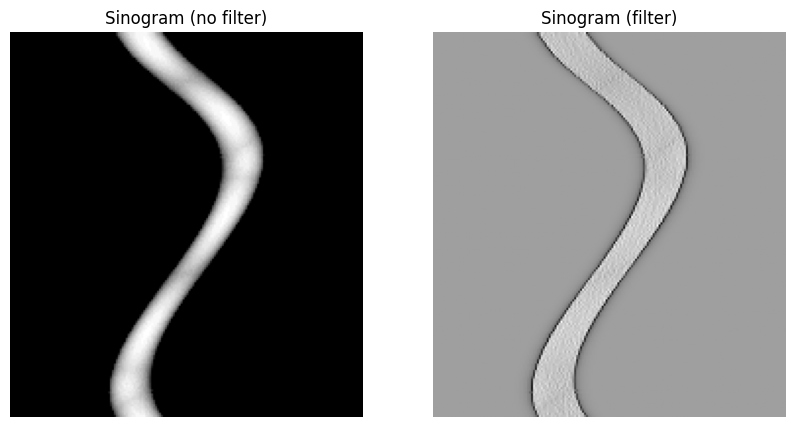

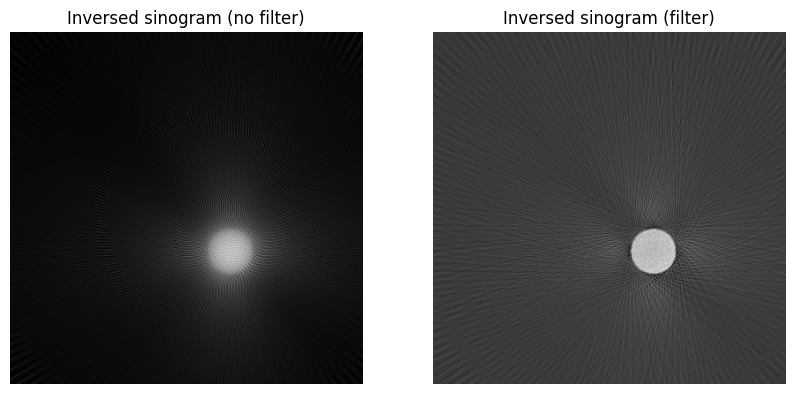

In [ ]:
filenames = glob.glob(".\\dicom\\*.dcm")

interact(set_parameters,
         f=Dropdown(options=filenames, value='.\\dicom\\Kropka.dcm', description='Filename', layout=Layout(width='80%'), style={'description_width': '200px'}),
         d=IntSlider(value=180, min=90, max=720, step=30, description='Amount of detectors:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         arch=IntSlider(value=180, min=90, max=360, step=10, description='Detectors angular span:', layout=Layout(width='80%'), style={'description_width': '200px'}),
         i=IntSlider(value=2, min=1, max=10, step=1, description='Emiter-detectors rotate steps:', layout=Layout(width='80%'), style={'description_width': '200px'})
)

interact(set_is_filter, val=Checkbox(value=True, description='Sinogram filtering'))

button = Button(description="Show results")
button.on_click(show_plot)

display(button)